# Strategy Simulation (fast version)

In [79]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:
import financial.data as fd
import financial.portfolio as fp
import financial.strategies.simulation as fss

import os

In [81]:
from financial.io.cache import NoUpdateStrategy
from financial.io.file.cache import FileCache

print(os.environ["DATA"])
print(os.environ["CACHE"])
ds = fd.CachedDataStore(path=os.environ["DATA"], cache=FileCache(cache_path=os.environ["CACHE"]+"/", update_strategy=NoUpdateStrategy()))

print(ds)

/home/manidmt/Universidad/TFG/OTRI/data
/home/manidmt/Universidad/TFG/OTRI/cache
CachedDataStore with 946 data sources [cache stats: {'size': 0, 'hit': 0, 'miss': 0, 'write': 0, 'read': 0, 'update': 0}]


# Signals

In [82]:
import financial.strategies.technical.indicator as st

# Momentum
    
momentum1m = st.Momentum()
momentum1m.set_parameters({'delay': 20})

momentum3m = st.Momentum()
momentum3m.set_parameters({'delay': 60})

momentum4m = st.Momentum()
momentum4m.set_parameters({'delay': 84})

momentum6m = st.Momentum()
momentum6m.set_parameters({'delay': 126})

momentum8m = st.Momentum()
momentum8m.set_parameters({'delay': 168})

momentum9m = st.Momentum()
momentum9m.set_parameters({'delay': 189})
       
momentum1y = st.Momentum()
momentum1y.set_parameters({'delay': 252})
    
# Aggregation

indicator_ferrer = st.Mean()
indicator_ferrer.set_parameters({'components': [momentum4m.to_dict(), momentum6m.to_dict(), momentum8m.to_dict()]})
print(indicator_ferrer.to_dict())    
    
indicator_requejo = st.Mean() # st.Sum() # Average instead of sum to make it comparable
indicator_requejo.set_parameters({'components': [momentum1m.to_dict(), momentum3m.to_dict(), momentum6m.to_dict(), momentum9m.to_dict(), momentum1y.to_dict()]})
print(indicator_requejo.to_dict())  


{'type': 'financial.strategies.technical.indicator.Mean', 'components': [{'type': 'financial.strategies.technical.indicator.Momentum', 'delay': 84}, {'type': 'financial.strategies.technical.indicator.Momentum', 'delay': 126}, {'type': 'financial.strategies.technical.indicator.Momentum', 'delay': 168}]}
{'type': 'financial.strategies.technical.indicator.Mean', 'components': [{'type': 'financial.strategies.technical.indicator.Momentum', 'delay': 20}, {'type': 'financial.strategies.technical.indicator.Momentum', 'delay': 60}, {'type': 'financial.strategies.technical.indicator.Momentum', 'delay': 126}, {'type': 'financial.strategies.technical.indicator.Momentum', 'delay': 189}, {'type': 'financial.strategies.technical.indicator.Momentum', 'delay': 252}]}


In [83]:
from financial.momentum.exponentialIndicator import ExponentialRegressionIndicator

indicator_exponential = ExponentialRegressionIndicator()

# Strategies

In [84]:
import financial.strategies.allocation as fsa
import financial.strategies.filter as fsf
import financial.strategies.rank as fsr

# Asset Universe

universe_ferrer = ['XLI', 'XLF', 'XLV', 'XLK', 'XLC', 'XLU', 'XLY', 'XLB', 'XLE', 'XLP',
                    'TLT', 'TIP', 'IEF', 'SHY', 'AGG', 'VNQ', 'GLD', 'DBC'] # IAU excluded
    
universe_requejo = ['XLE', 'XLF', 'XLU', 'XLI', 'XLK', 'XLV', 'XLY', 'XLP', 'XLB', 'XOP',
                    'XHB', 'XME', 'XRT', 'XTL', 'TLT', 'DBC']
    
universe_ing = ['XLI', 'XLF', 'XLV', 'XLK', 'XLY', 'XLB', 'XLP', 
                'SPY', 'DJE', 'NASD', 
                'IOGP', 'IQQH', 'RBOT', 'HEAL', 
                'PHAU', 'LYTR', 'GLRE']

universe_ing_eur = ['ZPDM', 'ZPDI', 'ZPDS', 'ZPDH', 'ZPDT', 'ZPDD', 'ZPDF',
                   'SPY5', 'DJE', 'UST', 'LYTR', 'IQQH'] # , 'IOGP', 'GLRE', 'PHAU', 'HEAL', 'RBOT']

from typing import List

def universe_report(tickers: List[str]):
    for ticker in tickers:
        metadata = ds.get_metadata(ticker)
        #print(metadata)
        print(f"{ticker:4} {metadata['currency']} {metadata['since']} {metadata['isin']} {metadata['description']}")

print("HUGO FERRER'S UNIVERSE")
universe_report(universe_ferrer)

print("DANIEL REQUEJO'S UNIVERSE")
universe_report(universe_requejo)

print("ING'S UNIVERSE")
universe_report(universe_ing)

print("ING'S UNIVERSE [EUR]")
universe_report(universe_ing_eur)


# Asset ranking strategies

ferrer_refuge = None # refuge
ferrer_filter = fsf.CompositeAssetFilter( [fsf.TopKAssetFilter(k=10), fsf.MinimumValueAssetFilter(threshold=0.0)] )
ferrer_allocation = fsa.FixedWeightAllocation(0.10)
ferrer_strategy = fsr.AssetRankingStrategy("HUGO FERRER'S STRATEGY", universe_ferrer,indicator_ferrer, ferrer_filter, ferrer_allocation, ferrer_refuge)
print(ferrer_strategy)

requejo_filter = fsf.TopKAssetFilter(k=3)
requejo_allocation = fsa.EqualWeightAllocation()
requejo_strategy = fsr.AssetRankingStrategy("DANIEL REQUEJO'S STRATEGY", universe_requejo, indicator_requejo, requejo_filter, requejo_allocation)    
print(requejo_strategy)

ferrer_strategy_ing = fsr.AssetRankingStrategy("ING @ Ferrer's strategy", universe_ing_eur, indicator_ferrer, ferrer_filter, ferrer_allocation)
print(ferrer_strategy_ing)

requejo_strategy_ing = fsr.AssetRankingStrategy("ING @ Requejo's strategy", universe_ing_eur, indicator_requejo, requejo_filter, requejo_allocation)
print(requejo_strategy_ing)

exp_filter = fsf.TopKAssetFilter(k=10)
exp_allocation = fsa.EqualWeightAllocation()
exp_strategy = fsr.AssetRankingStrategy("Exponential Strategy", universe_ing_eur, indicator_exponential, exp_filter, exp_allocation)
print(exp_strategy)


HUGO FERRER'S UNIVERSE
XLI  USD 02/01/2001 US81369Y7040 Industrial SPDR Select Sector ETF
XLF  USD 30/03/2001 US81369Y6059 Financial SPDR Select Sector ETF
XLV  USD 02/01/2001 US81369Y2090 Health Care SPDR Select Sector ETF
XLK  USD 02/01/2001 US81369Y8030 Technology SPDR Select Sector ETF
XLC  USD 20/06/2018 US81369Y8527 Communication Services SPDR Select Sector ETF
XLU  USD 27/11/2017 US81369Y8865 Utilities SPDR Select Sector ETF
XLY  USD 02/01/2001 US81369Y4070 Consumer Discretionary SPDR Select Sector ETF
XLB  USD 02/01/2001 US81369Y1001 Materials SPDR Select Sector ETF
XLE  USD 30/03/2001 US81369Y5069 Energy SPDR Select Sector ETF
XLP  USD 02/01/2001 US81369Y3080 Consumer Staples SPDR Select Sector ETF
TLT  USD 30/07/2002 US4642874329 US Bond 20+yr iShares ETF
TIP  USD 05/12/2003 US4642871762 US TIPS Bond iShares ETF
IEF  USD 07/07/2015 US4642874402 US Bond 7-10yr iShares ETF NASDAQ
SHY  USD 07/07/2015 US4642874576 US Bond 1-3yr iShares ETF NASDAQ
AGG  USD 29/09/2003 US4642872265 

# Porfolio performance

In [85]:
portfolio = fp.StockPortfolio("Stocks")
portfolio.add('$$$', '2001-01-01', 1000000, 1000000)

print(portfolio)

for ticker in portfolio.lots:
    print(portfolio.lots[ticker])
    
print(f"- Cost:  ${portfolio.cost():10.2f}")
print(f"- Value: ${portfolio.value(ds):10.2f}")
print(f"- Gain:  ${portfolio.gain(ds):>10.2f}  {100*portfolio.gain(ds)/portfolio.cost():>6.2f}%")
print()

fss.SimulationReport.value_report(ds,portfolio,start_year=2000)
print()
fss.SimulationReport.performance_report(ds,portfolio,start_year=2000)
fss.SimulationReport.performance_report_stocks(ds,portfolio,start_year=2000)


Stocks: ['$$$']
$$$: [{'index': '2001-01-01', 'stocks': 1000000, 'cost': 1000000}]
- Cost:  $1000000.00
- Value: $1000000.00
- Gain:  $      0.00    0.00%

           YEAR        Jan        Feb        Mar        Apr        May        Jun        Jul        Aug        Sep        Oct        Nov        Dec
  2000:       0.00                                                                                                
  2001: 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00
  2002: 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00
  2003: 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00
  2004: 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00 1000000.00

In [86]:
import financial.portfolios.statistics as fps

assets = {'^GSPC': 1.0}
target = fp.WeightedPortfolio.from_assets("Target", assets)
print(target)

print("Daily returns")
benchmark_returns = target.returns(ds,'2015-12-31','2023-12-31')
print(benchmark_returns)
print("Monthly returns")
benchmark_monthly_returns = fss.SimulationUtilities.monthly_returns(ds,target,2016,2023)
print(benchmark_monthly_returns)
benchmark_cumulative_returns = fps.CumulativeReturn().get_series(benchmark_monthly_returns)
print("Cumulative returns")
print(benchmark_cumulative_returns)


fss.SimulationReport.performance_report(ds, target, 2001)

print("\n Cumulative return")
fss.SimulationReport.cumulative_report(ds, target, 2001)


Target:
      ticker  weight  cost  isin description
^GSPC  ^GSPC     1.0  None  None        None
Daily returns
2016-01-04   -0.015304
2016-01-05    0.002012
2016-01-06   -0.013115
2016-01-07   -0.023700
2016-01-08   -0.010838
                ...   
2023-12-22    0.001660
2023-12-26    0.004232
2023-12-27    0.001430
2023-12-28    0.000370
2023-12-29   -0.002826
Length: 2012, dtype: float64
Monthly returns
2016-01-31   -0.050735
2016-02-29   -0.004128
2016-03-31    0.065991
2016-04-30    0.002699
2016-05-31    0.015325
                ...   
2023-08-31   -0.017716
2023-09-30   -0.048719
2023-10-31   -0.021980
2023-11-30    0.089179
2023-12-31    0.044229
Name: return, Length: 96, dtype: float64
Cumulative returns
2016-01-31   -0.050735
2016-02-29   -0.054654
2016-03-31    0.007730
2016-04-30    0.010450
2016-05-31    0.025935
                ...   
2023-08-31    1.205378
2023-09-30    1.097933
2023-10-31    1.051821
2023-11-30    1.234801
2023-12-31    1.333645
Name: return, Length: 96

# Strategy simulation 

In [87]:
%%time
import financial.strategies.rebalance as fsrebalance

strategy = exp_strategy #ferrer_strategy_ing #ferrer_strategy
benchmark = fp.BenchmarkPortfolio("^GSPC")
market = ds.get_data("^GSPC")
rebalancing = fsrebalance.MonthlyRebalancingSchedule(+2,market) # +1 first day, -1 last day

print("STRATEGY")
print(strategy)
print("BENCHMARK")
print(benchmark)
print("REBALANCING")
print(rebalancing)
        
simulation = fss.FastStockStrategySimulation(ds, strategy, rebalancing, market)
#simulation.verbose = True  # verbose 30.4s vs. 15.4s without trading details
simulation.simulate(start_year=2016, end_year=2023)


STRATEGY
Exponential Strategy
- 12 asset universe: ['ZPDM', 'ZPDI', 'ZPDS', 'ZPDH', 'ZPDT', 'ZPDD', 'ZPDF', 'SPY5', 'DJE', 'UST', 'LYTR', 'IQQH']
- Indicator: {'type': 'financial.momentum.exponentialIndicator.ExponentialRegressionIndicator', 'lookahead': 20, 'horizon': 90, 'model': 'exponential'}
BENCHMARK
^GSPC(^GSPC)
REBALANCING
Rebalancing schedule: Monthly rebalancing on 2
SIMULATING 2016...
+ Rebalance @ 2015-12-01
{'ZPDT': 0.1, 'UST': 0.1, 'ZPDD': 0.1, 'DJE': 0.1, 'ZPDI': 0.1, 'SPY5': 0.1, 'ZPDM': 0.1, 'ZPDS': 0.1, 'ZPDF': 0.1, 'ZPDH': 0.1}
+ Trade @ 2015-12-02
- Changes: {'ZPDT': 4926, 'ZPDM': 5523, 'UST': 5705, 'ZPDS': 5085, 'ZPDI': 5178, '$$$': -999663.864032149, 'ZPDF': 5241, 'ZPDH': 5454, 'SPY5': 502, 'ZPDD': 4995, 'DJE': 584}
- Rotation: 99.97%
+ Rebalance @ 2015-12-31
{'UST': 0.5, 'DJE': 0.5}
+ Trade @ 2016-01-04
- Changes: {'SPY5': -502, 'ZPDT': -4926, 'ZPDM': -5523, 'UST': 22679, 'ZPDS': -5085, 'DJE': 2379, 'ZPDD': -4995, '$$$': -205.3711437508464, 'ZPDH': -5454, 'ZPDF':

In [88]:
simulation.portfolio_target_report()


2015-12-01: {'ZPDT': 0.1, 'UST': 0.1, 'ZPDD': 0.1, 'DJE': 0.1, 'ZPDI': 0.1, 'SPY5': 0.1, 'ZPDM': 0.1, 'ZPDS': 0.1, 'ZPDF': 0.1, 'ZPDH': 0.1}
2015-12-31: {'UST': 0.5, 'DJE': 0.5}
2016-02-01: {'ZPDS': 0.1, 'ZPDH': 0.1, 'ZPDT': 0.1, 'UST': 0.1, 'SPY5': 0.1, 'ZPDD': 0.1, 'ZPDI': 0.1, 'DJE': 0.1, 'ZPDF': 0.1, 'ZPDM': 0.1}
2016-03-01: {'ZPDS': 0.1, 'ZPDH': 0.1, 'ZPDI': 0.1, 'ZPDT': 0.1, 'SPY5': 0.1, 'ZPDD': 0.1, 'DJE': 0.1, 'ZPDM': 0.1, 'UST': 0.1, 'ZPDF': 0.1}
2016-04-01: {'ZPDS': 0.1, 'ZPDI': 0.1, 'ZPDM': 0.1, 'ZPDT': 0.1, 'DJE': 0.1, 'SPY5': 0.1, 'ZPDD': 0.1, 'LYTR': 0.1, 'IQQH': 0.1, 'ZPDH': 0.1}
2016-04-29: {'ZPDM': 0.1, 'ZPDI': 0.1, 'DJE': 0.1, 'ZPDT': 0.1, 'ZPDS': 0.1, 'SPY5': 0.1, 'ZPDD': 0.1, 'LYTR': 0.1, 'UST': 0.1, 'ZPDF': 0.1}
2016-06-01: {'ZPDM': 0.1, 'ZPDI': 0.1, 'LYTR': 0.1, 'ZPDF': 0.1, 'DJE': 0.1, 'ZPDD': 0.1, 'SPY5': 0.1, 'ZPDT': 0.1, 'ZPDH': 0.1, 'UST': 0.1}
2016-07-01: {'LYTR': 0.1, 'ZPDM': 0.1, 'ZPDH': 0.1, 'ZPDF': 0.1, 'ZPDI': 0.1, 'DJE': 0.1, 'SPY5': 0.1, 'ZPDS': 0.1, 

In [89]:
simulation.simulation_trading_report()

2015-12-02: 99.97% {'ZPDT': 4926, 'ZPDM': 5523, 'UST': 5705, 'ZPDS': 5085, 'ZPDI': 5178, '$$$': -999663.864032149, 'ZPDF': 5241, 'ZPDH': 5454, 'SPY5': 502, 'ZPDD': 4995, 'DJE': 584}
2016-01-04: 80.08% {'SPY5': -502, 'ZPDT': -4926, 'ZPDM': -5523, 'UST': 22679, 'ZPDS': -5085, 'DJE': 2379, 'ZPDD': -4995, '$$$': -205.3711437508464, 'ZPDH': -5454, 'ZPDF': -5241, 'ZPDI': -5178}
2016-02-02: 79.98% {'SPY5': 496, 'ZPDT': 4774, 'ZPDM': 5874, 'UST': -22632, 'ZPDS': 4496, 'DJE': -2377, 'ZPDD': 4956, '$$$': -46.06950490028248, 'ZPDH': 5368, 'ZPDF': 5483, 'ZPDI': 5190}
2016-03-02: 0.96% {'SPY5': 5, 'ZPDT': 102, 'ZPDM': -331, 'UST': 38, 'ZPDS': 111, 'ZPDD': 49, '$$$': -25.924866104044554, 'ZPDH': 99, 'ZPDF': 37, 'ZPDI': -181}
2016-04-04: 20.21% {'IQQH': 19525, 'SPY5': 1, 'ZPDT': -86, 'ZPDM': -47, 'UST': -5790, 'DJE': -5, 'ZPDD': 25, '$$$': 17.83311587104673, 'LYTR': 6723, 'ZPDH': 76, 'ZPDF': -5520, 'ZPDI': -4}
2016-05-02: 21.04% {'IQQH': -19525, 'SPY5': 4, 'ZPDT': 332, 'ZPDM': -207, 'UST': 6056, 'ZPD

In [90]:
rotation = simulation.monthly_rotation()
print(f"Average monthly rotation (exponential strategy): {100*rotation:.2f}%")
rotation_ferrer = simulation_ferrer.monthly_rotation()
print(f"Average monthly rotation (ferrer strategy): {100*rotation:.2f}%")

Average monthly rotation (exponential strategy): 32.71%
Average monthly rotation (ferrer strategy): 32.71%


In [91]:
year_returns = simulation.year_returns()
#print(year_returns)

print("\nSTRATEGY RETURNS")
for year in year_returns:
    print(f"{year}: {100*year_returns[year]:6.2f}%")
    

cumulative = simulation.cumulative_returns(year_returns)

print("\nCUMULATIVE RETURNS")
for year in cumulative:
    print(f"{year}: {100*cumulative[year]:6.2f}%")



STRATEGY RETURNS
2016:  11.40%
2017:   7.50%
2018:  -8.21%
2019:  38.90%
2020:  11.76%
2021:  35.61%
2022:  -8.59%
2023:   6.44%

CUMULATIVE RETURNS
2016:  11.40%
2017:  19.76%
2018:   9.92%
2019:  52.68%
2020:  70.64%
2021: 131.40%
2022: 111.51%
2023: 125.14%


In [92]:
simulation.simulation_year_report()

2016
- Cost:  $1000000.00
- Value: $1070438.69
- Gain:  $  70438.69    7.04%
2017
- Cost:  $1000000.00
- Value: $1113392.84
- Gain:  $ 113392.84   11.34%
2018
- Cost:  $1000000.00
- Value: $ 930570.09
- Gain:  $ -69429.91   -6.94%
2019
- Cost:  $1000000.00
- Value: $1389016.60
- Gain:  $ 389016.60   38.90%
2020
- Cost:  $1000000.00
- Value: $1117601.69
- Gain:  $ 117601.69   11.76%
2021
- Cost:  $1000000.00
- Value: $1387934.92
- Gain:  $ 387934.92   38.79%
2022
- Cost:  $1000000.00
- Value: $ 945112.33
- Gain:  $ -54887.67   -5.49%
2023
- Cost:  $1000000.00
- Value: $1002317.98
- Gain:  $   2317.98    0.23%


In [93]:
%%time

year = 2016
monthly_returns = simulation.monthly_returns(year)
#print(monthly_returns)
cumulative_returns = simulation.cumulative_returns(monthly_returns)
year_return = cumulative_returns[12]

print("Monthly returns")
returns_str = [f"{100*month_return:>6.2f}%" for month_return in monthly_returns.values()]
print(f"  {year}:           {100*year_return:>6.2f}% " + " ".join(returns_str))

print("Monthly cumulative returns")
returns_str = [f"{100*month_return:>6.2f}%" for month_return in cumulative_returns.values()]
print(f"  {year}:           {100*year_return:>6.2f}% " + " ".join(returns_str))

print()
print("SERIES")
print("Monthly returns")
monthly_returns = simulation.returns()
print(monthly_returns)
cumulative_returns = fps.CumulativeReturn().get_series(monthly_returns)
print("Cumulative returns")
print(cumulative_returns)

Monthly returns
  2016:            11.40%  -7.09%   1.45%   0.59%   0.36%   4.47%  -0.66%   2.57%   0.21%  -0.86%   0.74%   7.32%   2.39%
Monthly cumulative returns
  2016:            11.40%  -7.09%  -5.74%  -5.19%  -4.85%  -0.59%  -1.25%   1.29%   1.50%   0.63%   1.38%   8.80%  11.40%

SERIES
Monthly returns
2016-01-31   -0.070885
2016-02-29    0.014514
2016-03-31    0.005854
2016-04-30    0.003598
2016-05-31    0.044692
                ...   
2023-08-31    0.000575
2023-09-30   -0.016538
2023-10-31   -0.032910
2023-11-30    0.047676
2023-12-31    0.038156
Length: 96, dtype: float64
Cumulative returns
2016-01-31   -0.070885
2016-02-29   -0.057400
2016-03-31   -0.051882
2016-04-30   -0.048471
2016-05-31   -0.005945
                ...   
2023-08-31    1.176423
2023-09-30    1.140428
2023-10-31    1.069988
2023-11-30    1.168676
2023-12-31    1.251424
Length: 96, dtype: float64
CPU times: user 9.35 s, sys: 37.8 ms, total: 9.39 s
Wall time: 9.39 s


In [94]:
import pandas as pd
benchmark_series = pd.Series(benchmark_monthly_returns)
difference = monthly_returns - benchmark_series
print(difference)

print("Better than benchmark")
print(sum(difference>0))
print(difference[difference>0])
print(sum(difference[difference>0]))

print("Worse than benchmark")
print(sum(difference<0))
print(difference[difference<0])
print(sum(difference[difference<0]))

2016-01-31   -0.020150
2016-02-29    0.018642
2016-03-31   -0.060137
2016-04-30    0.000899
2016-05-31    0.029367
                ...   
2023-08-31    0.018291
2023-09-30    0.032181
2023-10-31   -0.010930
2023-11-30   -0.041504
2023-12-31   -0.006073
Length: 96, dtype: float64
Better than benchmark
50
2016-02-29    0.018642
2016-04-30    0.000899
2016-05-31    0.029367
2016-08-31    0.003368
2016-10-31    0.026834
2016-11-30    0.039044
2016-12-31    0.005669
2017-02-28    0.017404
2017-07-31    0.022696
2017-09-30    0.010511
2017-10-31    0.026699
2017-12-31    0.005308
2018-02-28    0.026362
2018-04-30    0.034517
2018-08-31    0.004800
2018-09-30    0.002298
2018-10-31    0.025929
2019-02-28    0.007267
2019-03-31    0.004389
2019-04-30    0.002161
2019-05-31    0.061304
2019-07-31    0.035928
2019-08-31    0.004317
2019-09-30    0.008075
2019-11-30    0.020291
2020-01-31    0.020325
2020-02-29    0.005125
2020-03-31    0.024056
2020-06-30    0.004879
2020-08-31    0.014704
2020-

In [95]:
drawdown = fps.MaximumDrawdown().get_series(monthly_returns)
print(drawdown)
print(min(drawdown))

benchmark_drawdown = fps.MaximumDrawdown().get_series(benchmark_returns) # benchmark_monthly_returns)
print(benchmark_drawdown)
print(min(benchmark_drawdown))

2016-01-31   -0.070885
2016-02-29   -0.057400
2016-03-31   -0.051882
2016-04-30   -0.048471
2016-05-31   -0.005945
                ...   
2023-08-31   -0.059443
2023-09-30   -0.074998
2023-10-31   -0.105440
2023-11-30   -0.062791
2023-12-31   -0.027031
Length: 96, dtype: float64
-0.1720663213644189
2016-01-04   -0.015304
2016-01-05   -0.013322
2016-01-06   -0.026263
2016-01-07   -0.049341
2016-01-08   -0.059645
                ...   
2023-12-22   -0.008742
2023-12-26   -0.004547
2023-12-27   -0.003123
2023-12-28   -0.002754
2023-12-29   -0.005573
Length: 2012, dtype: float64
-0.3392496000265328


In [96]:
%%time

simulation.simulation_performance_report()

         return     YEAR     Jan     Feb     Mar     Apr     May     Jun     Jul     Aug     Sep     Oct     Nov     Dec
  2016:   11.40%   11.40%  -7.09%   1.45%   0.59%   0.36%   4.47%  -0.66%   2.57%   0.21%  -0.86%   0.74%   7.32%   2.39%
  2017:   19.76%    7.50%  -0.99%   5.46%  -0.53%  -1.01%   0.24%  -2.04%   4.20%  -5.81%   2.98%   4.89%  -1.05%   1.51%
  2018:    9.92%   -8.21%   1.81%  -1.26%  -4.83%   3.72%  -0.01%  -0.88%   2.31%   3.51%   0.66%  -4.35%   0.78%  -9.18%
  2019:   52.68%   38.90%   7.09%   3.70%   2.23%   4.15%  -0.45%   5.41%   4.91%  -1.38%   2.53%  -1.15%   5.43%   1.25%
  2020:   70.64%   11.76%   1.87%  -7.90% -10.11%  10.82%  -3.05%   2.33%   1.26%   8.48%   0.51%  -1.73%   8.97%   1.96%
  2021:  131.40%   35.61%   1.92%   2.47%   5.57%   2.67%  -0.21%   3.95%   2.35%   2.95%  -1.47%   6.91%   1.50%   2.50%
  2022:  111.51%   -8.59%  -6.41%  -0.82%   6.27%   0.05%  -3.23%  -5.15%   9.97%  -0.67%  -5.62%   4.73%  -0.94%  -5.65%
  2023:  125.14%    6.44%

In [97]:
%%time

print("MONTHLY RETURNS")
fss.SimulationReport.simulation_report(monthly_returns, fss.accumulate_return)
print("CUMULATIVE RETURNS")
fss.SimulationReport.simulation_report(cumulative_returns, fss.accumulate_last)
print("SIMULATION DRAWDOWN")
fss.SimulationReport.simulation_report(drawdown, fss.accumulate_min)

MONTHLY RETURNS
          TOTAL     YEAR     Jan     Feb     Mar     Apr     May     Jun     Jul     Aug     Sep     Oct     Nov     Dec
  2016:   11.40%   11.40%  -7.09%   1.45%   0.59%   0.36%   4.47%  -0.66%   2.57%   0.21%  -0.86%   0.74%   7.32%   2.39%
  2017:   19.76%    7.50%  -0.99%   5.46%  -0.53%  -1.01%   0.24%  -2.04%   4.20%  -5.81%   2.98%   4.89%  -1.05%   1.51%
  2018:    9.92%   -8.21%   1.81%  -1.26%  -4.83%   3.72%  -0.01%  -0.88%   2.31%   3.51%   0.66%  -4.35%   0.78%  -9.18%
  2019:   52.68%   38.90%   7.09%   3.70%   2.23%   4.15%  -0.45%   5.41%   4.91%  -1.38%   2.53%  -1.15%   5.43%   1.25%
  2020:   70.64%   11.76%   1.87%  -7.90% -10.11%  10.82%  -3.05%   2.33%   1.26%   8.48%   0.51%  -1.73%   8.97%   1.96%
  2021:  131.40%   35.61%   1.92%   2.47%   5.57%   2.67%  -0.21%   3.95%   2.35%   2.95%  -1.47%   6.91%   1.50%   2.50%
  2022:  111.51%   -8.59%  -6.41%  -0.82%   6.27%   0.05%  -3.23%  -5.15%   9.97%  -0.67%  -5.62%   4.73%  -0.94%  -5.65%
  2023:  

STRATEGY vs. BENCHMARK


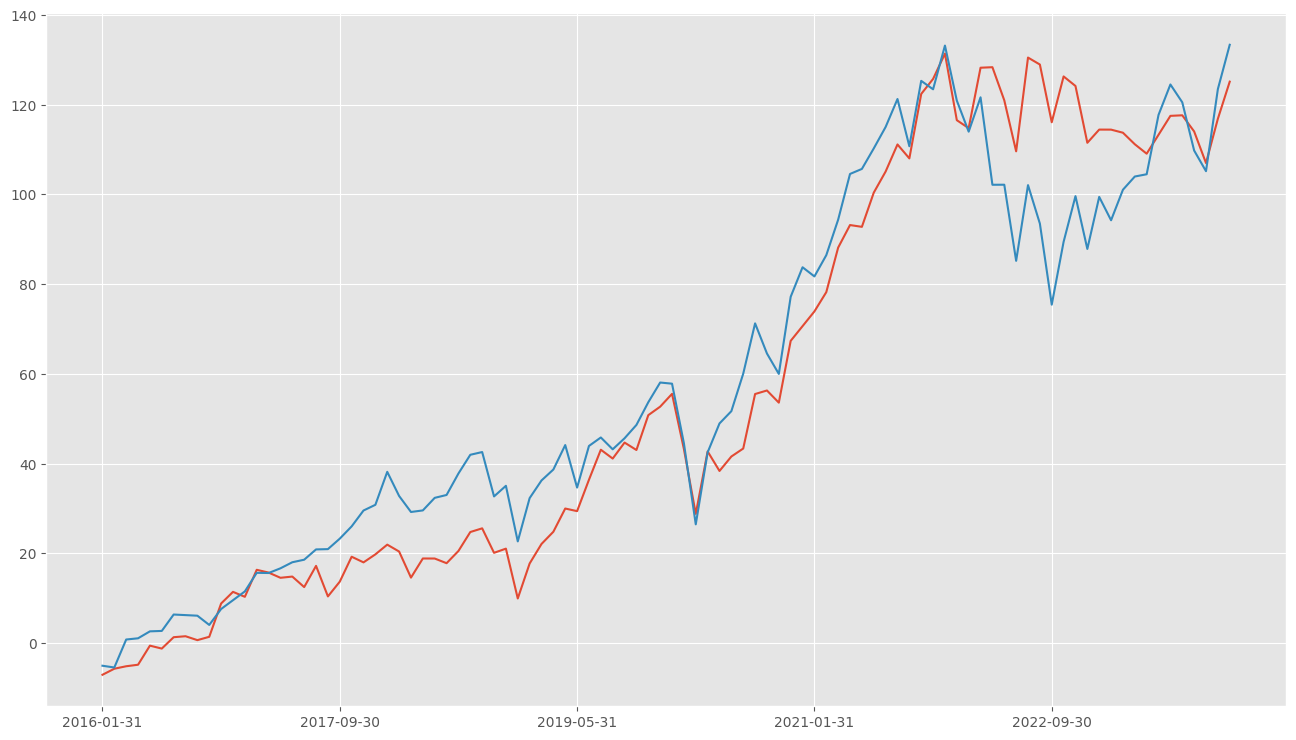

In [98]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

# Adjusting the size of matplotlib
import matplotlib as mpl

mpl.rc('figure', figsize=(16, 9))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')

benchmark = 100*benchmark_cumulative_returns
#benchmark = 100*fps.MaximumDrawdown().get_series(benchmark_monthly_returns)

data = 100*cumulative_returns
#data = 100*drawdown

#monthly_returns.plot(label=ticker)
data.plot()
benchmark.plot()
print("STRATEGY vs. BENCHMARK")